In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

from funcs.model import (daylength,
                         on_off,
                         lambert,
                         great_circle_distance,
                         dot_ensemble_circular,
                         full_model,
                         lightcurve_model,
                         aflare)

from funcs.helper import no_nan_inf
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

from mpl_toolkits.mplot3d import Axes3D

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
NumExpr defaulting to 8 threads.


ImportError: cannot import name 'full_model'

In [ ]:
def xyz(theta, phi):
    "convert spherical coordinates to cartesian"
    return np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)

%matplotlib inline

# plot a grid

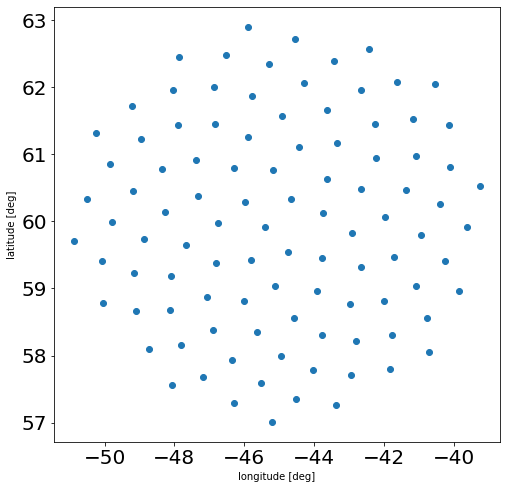

In [3]:
latdeg = 60
londeg = 45

latitudes, longitudes, pos = dot_ensemble_circular(latdeg/180*np.pi,londeg/180*np.pi,3,num_pts=100)
plt.figure(figsize=(8,8))
plt.scatter(longitudes/np.pi*180, latitudes/np.pi*180)
plt.xlabel("longitude [deg]")
plt.ylabel("latitude [deg]");

#plt.savefig(f"{CWD}/analysis/plots/model/dot_ensemble.png",dpi=300)

# Plot a model consisting of an ensemble of rotating flaring points on a sphere

In [10]:
latdeg = 30 # latitude in deg
rotation = 45.*np.pi/180 #peak time of flare
incdeg = 30 # inclination in deg
I = incdeg * np.pi / 180. # inclination in rad
phi = np.linspace(0,4*np.pi,2000) #time
ampl = 20 # amplitude
fwhm = 3. # FWHM
flare = aflare(phi, rotation, fwhm, ampl,) # underlying flare

# model light curve, esp. lambert factor and visibility:
lamb, onoff, m = lightcurve_model(phi, latitudes, -longitudes, flare, I) 

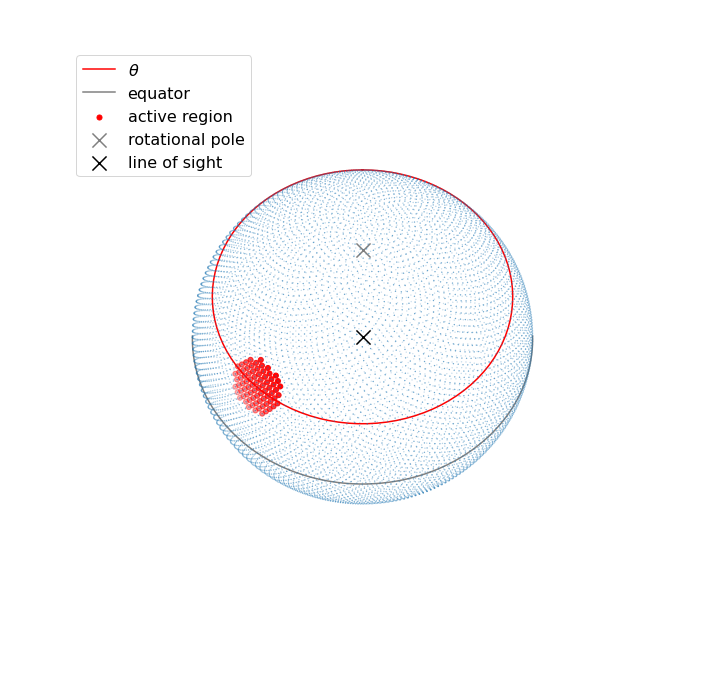

In [11]:
l=100 # resolution of lines to draw on the sphere
percent = 10 # fractional area of flaring area
num_pts = 1e4 # total number of grid points on the sphere
indices = np.arange(0, num_pts, dtype=float) + 0.5 
d = daylength(latdeg / 180*np.pi,i=I) # length of day at latitude latdeg when viewed at inclination I


phi = np.arccos(1 - 2*indices/num_pts) #latitudes of the grid
theta = np.pi * (1 + 5**0.5) * indices  #longitudes of the grid

# select grid points and convert from spherical to cartesian coordinates
a = np.where(great_circle_distance(latdeg/180*np.pi,
                                   rotation*np.pi/180, 
                                   np.pi/2 - phi%(2*np.pi), 
                                   theta%(np.pi*2)) < (percent/180*np.pi))[0]
phi2 = phi[a]
theta2 = theta[a]
x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
x2, y2, z2 = np.cos(theta2) * np.sin(phi2), np.sin(theta2) * np.sin(phi2), np.cos(phi2);

# Plot it!

fig=plt.figure(figsize=(12.4,12.5))
ax=fig.add_subplot(1,1,1,projection="3d")
ax.scatter(x, y, z, s=.1);
ax.scatter(x2, y2, z2, s=25.5, c="r", label="active region");

# active latitude

d = daylength(latdeg/180*np.pi,i=I)
phi = np.full(l,np.pi/2-latdeg*np.pi/180)
theta = np.linspace(-d*np.pi + rotation,d*np.pi + rotation,l)
xtheta, ytheta, ztheta = xyz(theta, phi)
ax.plot(xtheta, ytheta, ztheta, linewidth=1.5, c="r",label=r"$\theta$");

# equator

d = daylength(0,i=I)
phi = np.full(l,np.pi/2-0.01)
theta = np.linspace(-d*np.pi + rotation, d*np.pi + rotation,l)
xtheta, ytheta, ztheta = xyz(theta, phi)
ax.plot(xtheta, ytheta, ztheta, linewidth=1.5, c="grey", label="equator");

# rotational pole

ax.scatter([0,],[0,],[1.,],s=200,c="grey",marker="x",label="rotational pole")

# line of sight

theta, phi = [ rotation], [incdeg*np.pi/180]
x, y, z = xyz(theta, phi)
ax.scatter(x,y,z,s=200,c="k",marker="x", label="line of sight")

# layout

plt.legend(fontsize=16, loc=(0.1,0.75))
plt.axis('off')
ax.view_init(90-incdeg,  rotation*180/np.pi);

# plt.savefig(f"{CWD}/analysis/plots/model/spot_on_a_sphere.png",dpi=300)


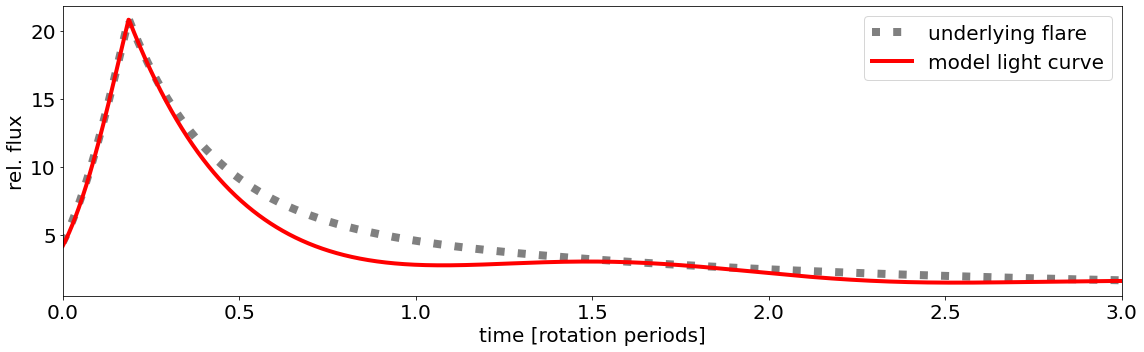

In [12]:
phi = np.linspace(0,6*np.pi,2000)
plt.figure(figsize=(16,5))
plt.plot(phi/2/np.pi,flare+1, label="underlying flare",c="grey",linestyle="dotted",linewidth=8)
plt.plot(phi/2/np.pi,m+1,linewidth=4, label="model light curve", c="r")
plt.xlabel("time [rotation periods]",fontsize=20)
plt.ylabel("rel. flux",fontsize=20)
plt.xlim(0,3)
plt.legend(fontsize=20)
#plt.yscale("log")
plt.tight_layout()
#plt.title(f"Flare with rel. amplitude={ampl}, and FWHM={fwhm} rotation periods",fontsize=20)
# plt.savefig(f"{CWD}/analysis/plots/model/rotating_flare.png",dpi=300);


# plot a rotationally modulated single-dot-on-the-surface flare

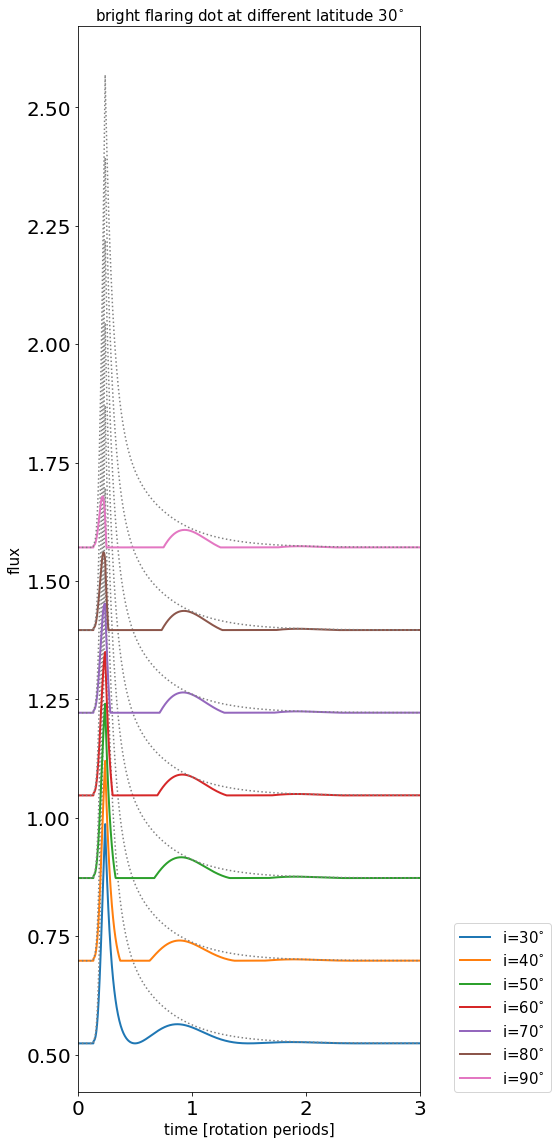

In [13]:
flare = aflare(phi, 1.5, 1.3, 1,)
plt.figure(figsize=(8,16))
l = latdeg/180*np.pi
I = np.arange(30,91,10)/180*np.pi
for i in I:
    D = daylength(l,i)
    modulation = lambert(phi,i,l)
    plt.plot(phi/2/np.pi,modulation*on_off(phi,D)*flare + i,label=f"i={i/np.pi*180:.0f}" + r"$^{\circ}$",
            linewidth=2,)
    plt.plot(phi/2/np.pi,flare + i,c="grey",linestyle="dotted")
plt.title(f"bright flaring dot at different latitude {latdeg}" + r"$^{\circ}$",fontsize=15)
plt.xlabel("time [rotation periods]",fontsize=15)
plt.ylabel("flux",fontsize=15)
plt.legend(loc=(1.1,0),fontsize=15)
plt.xlim(0,3)
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/rotating_bright_dot_flare.png",dpi=300)

# plot visibility as a function of day time

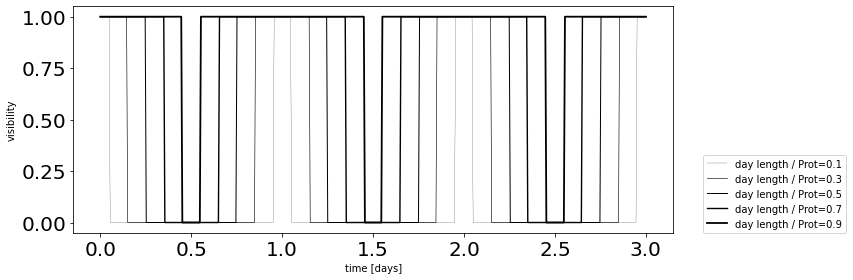

In [14]:
plt.figure(figsize=(12,4))
phi = np.linspace(0,6*np.pi,500) #(longitude)
daylengths = np.arange(.1,.91,.2)
for d in daylengths:
    plt.plot(phi/2/np.pi, on_off(phi,d), linewidth=d*2,c="k", label=f"day length / Prot={d:.1f}")
plt.legend(loc=(1.05,0))
plt.xlabel("time [days]")
plt.ylabel("visibility")
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/visibility_vs_day.png",dpi=300)

# plot daylengths

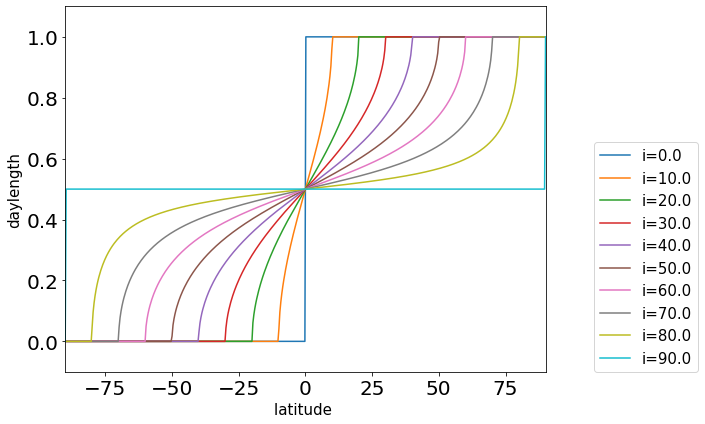

In [15]:
I = np.linspace(0,np.pi/2,10)
L = np.linspace(-np.pi/2,np.pi/2, 500)[::-1]
plt.figure(figsize=(10,6))

    
for i in I:
    dl = []
    for l in L:
        dl.append(daylength(l,i))
    plt.plot(L/np.pi*180,dl,label=f"i={i/np.pi*180:.1f}")
plt.xlabel("latitude ",fontsize=15)
plt.ylabel("daylength",fontsize=15)
plt.ylim(-.1,1.1)
plt.xlim(-90,90)
plt.legend(loc=(1.1,0),fontsize=15)
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/daylength.png",dpi=300)